# **N-Asset Efficient Frontier**

In [31]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import edhec_risk_kit203 as erk
import pandas as pd
import numpy as np

ind = erk.get_ind_returns()
er = erk.annualize_rets(ind["1996":"2000"], 12)
cov = ind["1996":"2000"].cov()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from scipy.optimize import minimize

<Axes: xlabel='Volatility'>

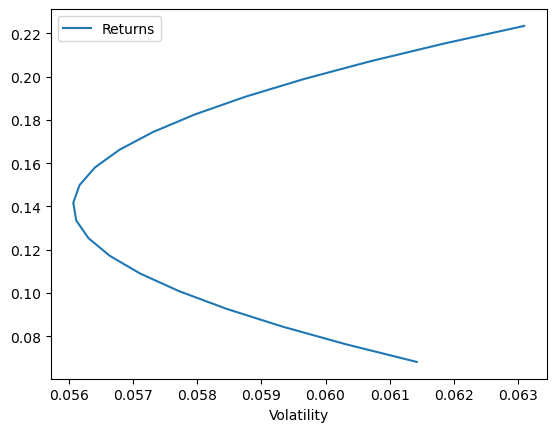

In [7]:
l =["Games", "Fin"]
erk.plot_ef2(20, er[l], cov.loc[l, l])

In [18]:
def minimize_vol(target_return, er, cov):
    """
    taregt-return -> W
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),)*n
    return_is_target = {
        'type': 'eq',
        'args': (er,),
        'fun': lambda weights, er: target_return - erk.portfolio_return(weights, er)
    }
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    results = minimize(erk.portfolio_vol, init_guess, 
                       args = (cov,), method='SLSQP',
                       options={'disp':False}, constraints = (return_is_target, weights_sum_to_1), bounds=bounds)
    return results.x

In [12]:
l

['Games', 'Fin']

In [20]:
w15 = erk.minimize_vol(0.15, er[l], cov.loc[l, l])
vol15 = erk.portfolio_vol(w15, cov.loc[l, l])
vol15

0.056163669406706564

In [21]:
w15

array([0.47287631, 0.52712369])

In [26]:
def optimal_weights(n_points, er, cov):
    """
    -> List of weights to run the optimizer on to minimize the vol
    """
    target_rs = np.linspace(er.min(), er.max(), n_points)
    weights = [minimize_vol(target_return, er, cov) for target_return in target_rs]
    return weights

def plot_ef(n_points, er, cov):
    """
    Plots the multi-asset efficient frontier
    """
    weights = optimal_weights(n_points, er, cov)
    rets = [erk.portfolio_return(w, er) for w in weights]
    vols = [erk.portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({
        "Returns": rets, 
        "Volatility": vols
    })
    return ef.plot.line(x="Volatility", y="Returns", style='.-')

<Axes: xlabel='Volatility'>

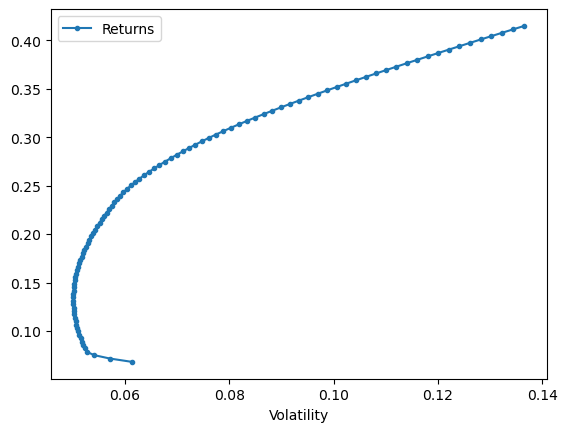

In [32]:
l = ["Smoke", "Games", "Coal", "Fin"]
erk.plot_ef(100, er[l], cov.loc[l, l])